<a href="https://colab.research.google.com/github/miltiadiss/Decision-Theory/blob/main/Project%202/Counterfeiting_of_banknotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Load data and apply Z-Score Normalization on features**

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data from csv
file_path = '/content/drive/MyDrive/data.csv'
data = pd.read_csv(file_path)

# Separate features (X) and target variable (y)
X = data.drop(columns=['class']) # Drop only column 'class' to keep the features
y = data['class'] # Keep only column 'class' which is the target

# Apply Z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns) # Convert the scaled data into a DataFrame

##**Question 1**

###**PCA**


Principal Components:
     variance  skewness  curtosis   entropy
PC1  0.248772  0.639323 -0.612707 -0.392389
PC2  0.754591 -0.050340 -0.153459  0.636010


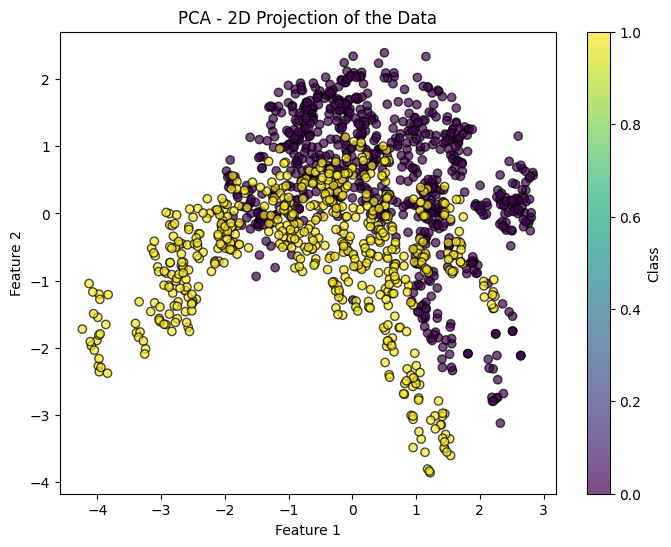

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the number of features to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)

# Convert the PCA result into a DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Split the data into 60% training, 20% validation, and 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_pca_df, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Display the contribution of each feature to each principal component
print("\nPrincipal Components:")
components_df = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])
print(components_df)

# Plot the PCA features
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(label='Class')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('PCA - 2D Projection of the Data')
plt.show()

###**Parzen Windows**

Accuracy for bandwidth 0.1: 0.8945
Accuracy for bandwidth 0.5: 0.8145
Accuracy for bandwidth 1.0: 0.8255
Accuracy for bandwidth 2.0: 0.7818
Accuracy for bandwidth 5.0: 0.7818


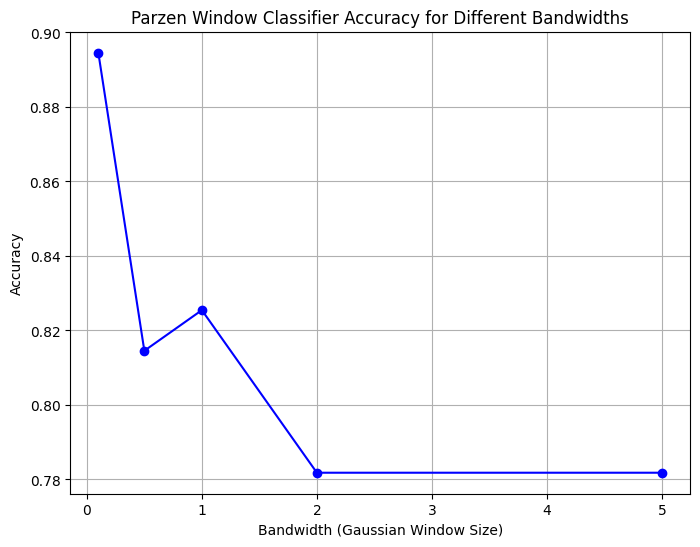

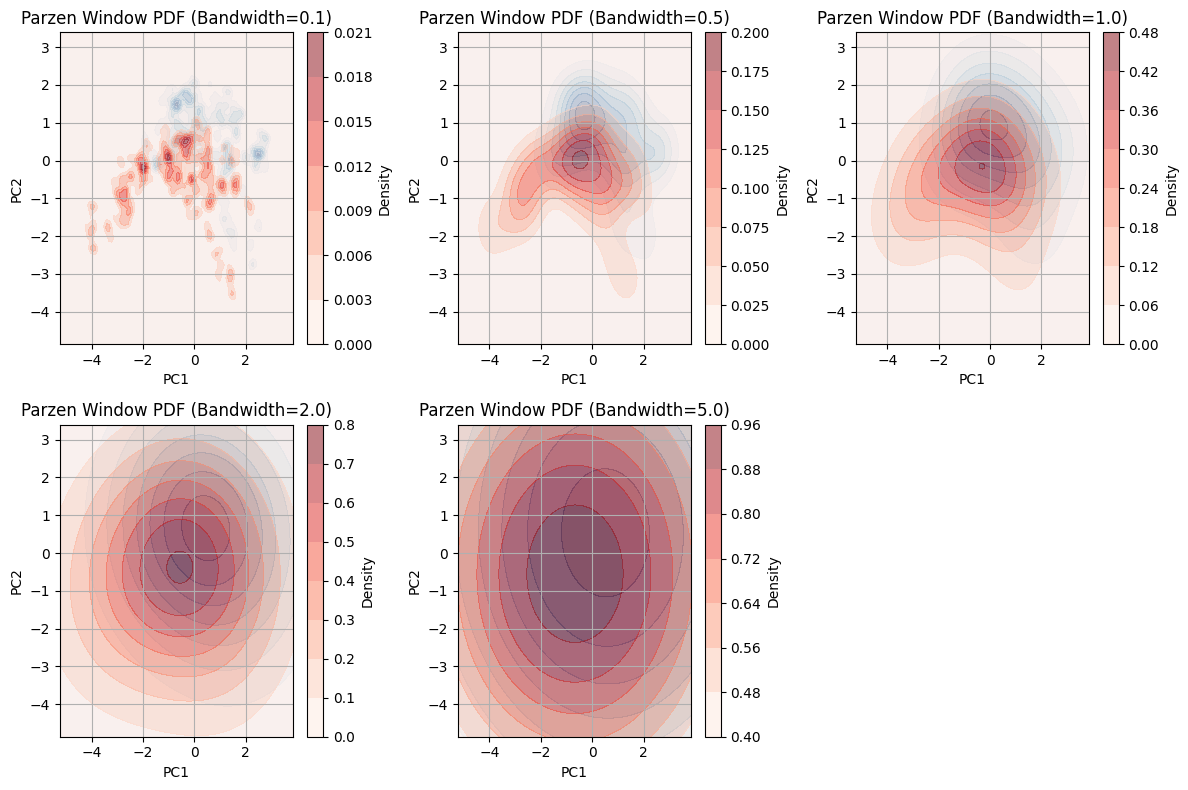

In [20]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parzen Window with Gaussian Kernel
def parzen_window(X_train, y_train, X_test, bandwidth):
    classes = np.unique(y_train)
    predictions = []

    for x_test in X_test.values:
        class_probabilities = []

        for c in classes:
            # Get the training data for the current class
            X_class = X_train[y_train == c]

            # Compute the Parzen window density estimate for the current class
            density = 0
            for x_train in X_class.values:
                # Gaussian kernel
                density += np.exp(-np.linalg.norm(x_test - x_train) ** 2 / (2 * bandwidth ** 2))

            # Normalize the density
            density /= len(X_class)
            class_probabilities.append(density)

        # Classify based on the highest density estimate
        predicted_class = classes[np.argmax(class_probabilities)]
        predictions.append(predicted_class)

    return np.array(predictions)

# Parzen Window with Gaussian Kernel for PDF estimation
def parzen_window_pdf(X_train, y_train, X_test, bandwidth):
    classes = np.unique(y_train)
    pdfs = {c: [] for c in classes}  # Dictionary to store PDFs for each class

    # For each test point, compute the density estimate for each class
    for x_test in X_test.values:
        for c in classes:
            # Get the training data for the current class
            X_class = X_train[y_train == c]

            # Compute the Parzen window density estimate for the current class
            density = 0
            for x_train in X_class.values:
                # Gaussian kernel
                density += np.exp(-np.linalg.norm(x_test - x_train) ** 2 / (2 * bandwidth ** 2))

            # Normalize the density
            density /= len(X_class)
            pdfs[c].append(density)

    return pdfs

# Generate a grid of points to plot the PDF
x_min, x_max = X_train['PC1'].min() - 1, X_train['PC1'].max() + 1
y_min, y_max = X_train['PC2'].min() - 1, X_train['PC2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Different bandwidths for Gaussian kernel
bandwidths = [0.1, 0.5, 1.0, 2.0, 5.0]

# Store accuracy for each bandwidth
accuracies = []

# Test Parzen window for different bandwidths
for bandwidth in bandwidths:
    # Apply Parzen window to classify the test data
    y_pred = parzen_window(X_train, y_train, X_test, bandwidth)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Accuracy for bandwidth {bandwidth}: {accuracy:.4f}")

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(bandwidths, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Bandwidth (Gaussian Window Size)')
plt.ylabel('Accuracy')
plt.title('Parzen Window Classifier Accuracy for Different Bandwidths')
plt.grid(True)
plt.show()

# Plot the PDFs for different bandwidths
plt.figure(figsize=(12, 8))

for bandwidth in bandwidths:
    # Compute the Parzen window PDF for the grid of points
    pdfs = parzen_window_pdf(X_train, y_train, pd.DataFrame(grid_points, columns=['PC1', 'PC2']), bandwidth)

    # Reshape the PDF values to match the grid shape
    Z_class_0 = np.array(pdfs[0]).reshape(xx.shape)
    Z_class_1 = np.array(pdfs[1]).reshape(xx.shape)

    # Plot the PDFs for each class
    plt.subplot(2, 3, bandwidths.index(bandwidth) + 1)
    plt.contourf(xx, yy, Z_class_0, alpha=0.5, cmap='Blues')
    plt.contourf(xx, yy, Z_class_1, alpha=0.5, cmap='Reds')
    plt.title(f'Parzen Window PDF (Bandwidth={bandwidth})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(label='Density')
    plt.grid(True)

plt.tight_layout()
plt.show()